In [1]:
from meu_modelo import RegLinBayesiana

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import jupyterthemes
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
import warnings
from bayes_opt import BayesianOptimization


jupyterthemes.stylefx.set_nb_theme('grade3')
plt.style.use('seaborn-whitegrid')


# Avaliação de técnicas probabilísticas para regressão em dados de características pessoais e fatores dietéticos

# Contextualização


* Estudos observacionais sugerem que baixas concentrações plasmáticas de retinol, beta-caroteno ou outros carotenóides podem estar associados a um maior risco de desenvolver câncer.

* Este estudo tem como objetivo investigar a relação entre características pessoais e fatores dietéticos e a concentração plasmática de retinol.


## Descrição dos dados Usados 

(https://www.openml.org/d/511)

 

**O conjunto de dados usado possui 315 entradas, 13 atributos preditores e 1 atributo alvo. Sendo os atributos Idade, Sexo e Fumante categóricos e os outros numéricos, inclusive o alvo.**


|**Descrição dos atributos**|
|-------------------------|
|AGE: Idade em anos (years)|
|SEX: Sexo (1=Masc, 2=Fem)|
|SMOKSTAT: Status de fumante (1=Nunca, 2=Ex-fumante, 3=Fumante)|
|QUETELET: IMC (PESO/(ALTURA^2))|
|VITUSE: Uso de vitamina (1=Sim, com frequência, 2=Yes, pouca frequência, 3=Não)|
|CALORIES: Calorias consumidas por dia.|
|FAT: Gramas de gordura consumidas por dia.|
|FIBER: Gramas de fibra consumidas por dia.|
|ALCOHOL: Quantidade de drinks alcoólicos consumidos por semana.|
|CHOLESTEROL: Coleterol consumido (mg por dia).|
|BETADIET: Betacaroteno na dieta consumido (mcg por dia).|
|RETDIET: Retinol na dieta consumido (mcg por dia)|
|BETAPLASMA: Plasma Betacaroteno (ng/ml)|
|RETPLASMA: Plasma Retinol (ng/ml) (ALVO)|

    

### Detalhamento da metodologia


Na primeira parte deste estudo será usado modelo de Regressão Linear Bayesiana com implementação própria usando orientação a objetos, que será comparado com um modelo modelo linear equivalente de regressão biblioteca scikit-learn.


Na segunda parte será usado a técnica de Otimização Bayesiana com um modelo de árvores mais complexo, o de Florestas Aleatórias, com o objetivo de avaliar a técnica de Otimização Bayesiana para este problema de regressão, comparando os resultados do modelo antes e depois do procedimento de otimização. Para o procedimento de otmização será utilizada a biblioteca "bayes_opt".


Nas duas partes da aplicação dos modelos serão usadas, bibliotecas clássicas do Python para o processo de aprendizado de máquina, tratamento, exploração, pré-processamento, seleção e avaliação de modelos: pandas e scikit-learn.


In [2]:
# Load data
plasma_retinol = fetch_openml(name='plasma_retinol',version = 1,as_frame=True)
X = plasma_retinol.data
y = plasma_retinol.target

In [3]:
X.head()

,AGE,SEX,SMOKSTAT,QUETELET,VITUSE,CALORIES,FAT,FIBER,ALCOHOL,CHOLESTEROL,BETADIET,RETDIET,BETAPLASMA
0,64.0,Female,Former,21.48380,Yes_fairly_often,1298.8,57.0,6.3,0.0,170.3,1945.0,890.0,200.0
1,76.0,Female,Never,23.87631,Yes_fairly_often,1032.5,50.1,15.8,0.0,75.8,2653.0,451.0,124.0
2,38.0,Female,Former,20.01080,Yes_not_often,2372.3,83.6,19.1,14.1,257.9,6321.0,660.0,328.0
3,40.0,Female,Former,25.14062,No,2449.5,97.5,26.5,0.5,332.6,1061.0,864.0,153.0
4,72.0,Female,Never,20.98504,Yes_fairly_often,1952.1,82.6,16.2,0.0,170.8,2863.0,1209.0,92.0


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   AGE          315 non-null    float64 
 1   SEX          315 non-null    category
 2   SMOKSTAT     315 non-null    category
 3   QUETELET     315 non-null    float64 
 4   VITUSE       315 non-null    category
 5   CALORIES     315 non-null    float64 
 6   FAT          315 non-null    float64 
 7   FIBER        315 non-null    float64 
 8   ALCOHOL      315 non-null    float64 
 9   CHOLESTEROL  315 non-null    float64 
 10  BETADIET     315 non-null    float64 
 11  RETDIET      315 non-null    float64 
 12  BETAPLASMA   315 non-null    float64 
dtypes: category(3), float64(10)
memory usage: 26.0 KB


**Exploração atributos categóricos.**

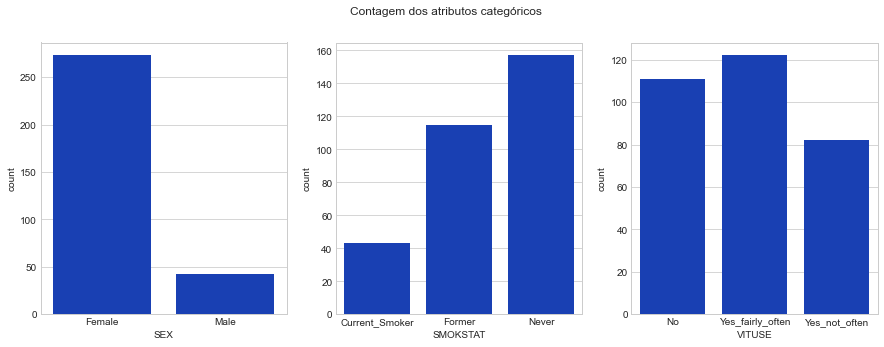

In [5]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.countplot(ax= axes[0], x="SEX", data=X, color='#0033CC')
sns.countplot(ax= axes[1], x="SMOKSTAT", data=X,color='#0033CC')
sns.countplot(ax= axes[2], x="VITUSE", data=X, color='#0033CC')
fig.suptitle('Contagem dos atributos categóricos')
plt.savefig('contagem')
plt.show()


**Tratamento de atributos categóricos ("One hot encoding")**

In [6]:
cat = X.select_dtypes(include='category', exclude=None).columns.to_list()

X_d = pd.get_dummies(X, columns=cat)

**Separação em dados de treino e de teste (30%)**

In [7]:
X_train, X_test, y_train , y_test = train_test_split(X_d, y, test_size = 0.3, random_state = 13)

**Exploração dos atributos numéricos**

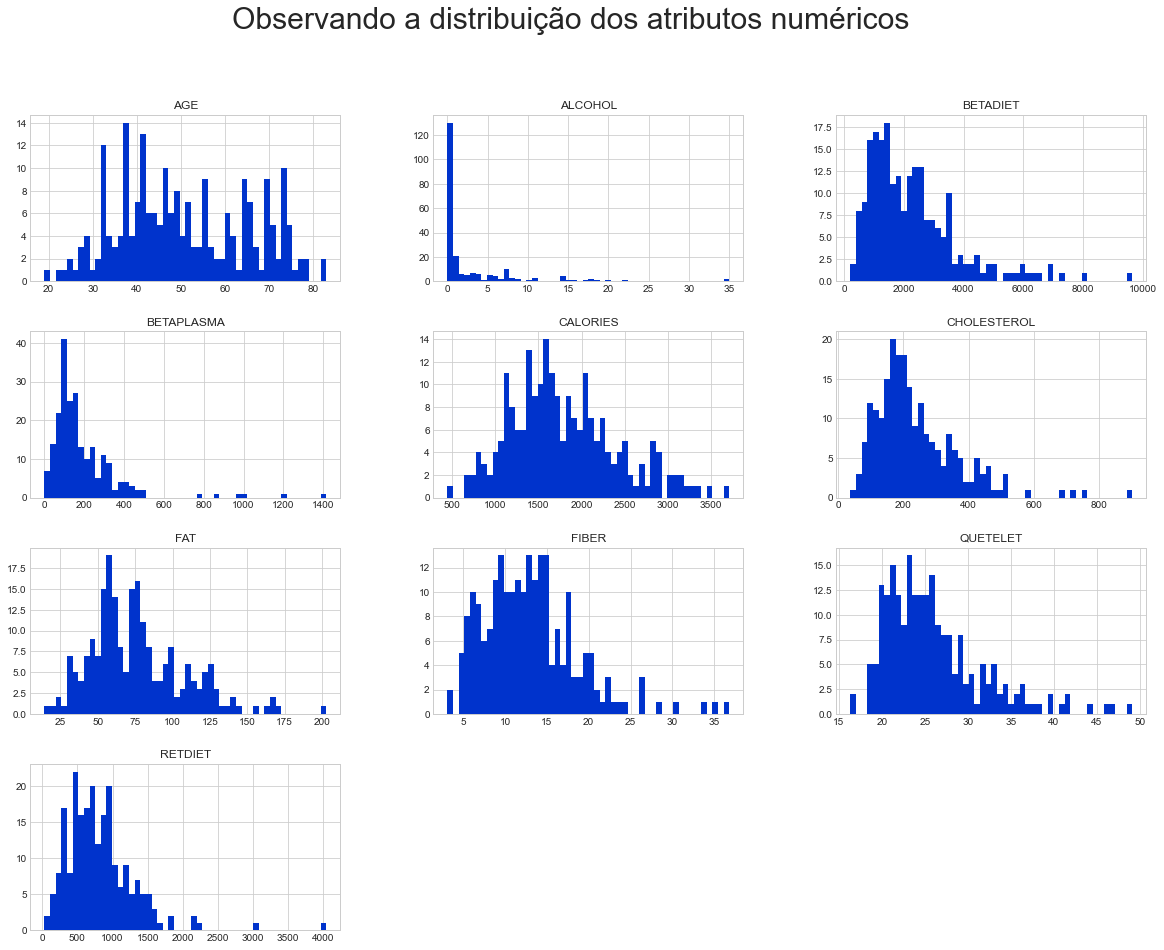

In [8]:
num = X.select_dtypes(include='float', exclude=None).columns.to_list()

X_train[num].hist(bins=50,figsize = (20,15),color='#0033CC')
plt.suptitle('Observando a distribuição dos atributos numéricos',size=30)
plt.savefig('histogramas')
plt.show()



**Remoção de outliers**

In [9]:
print("Os dados de treino tem {} entradas antes da remoção.".format(len(X_train)))
for col in num:
    mean = X_train[col].mean()
    std = X_train[col].std()
    cut = mean + 4*std
    X_train = X_train[X_train[col] < cut]

print("Os dados de treino tem {} entradas após a remoção.".format(len(X_train)))

y_train = y_train[X_train.index]
    

Os dados de treino tem 220 entradas antes da remoção.
Os dados de treino tem 210 entradas após a remoção.


**Normalização**

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Aplicação modelo Regressão Linear Bayesiana**

In [11]:
model = RegLinBayesiana(alpha=5 ,beta=0.05)
model.fit(X_train, y_train)
y_mean, y_std = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_mean))
print("A raiz do erro quadrático médio do modelo para estes dados é: {}.".format(rmse))

A raiz do erro quadrático médio do modelo para estes dados é: 278.28183486622305.


In [12]:
result = pd.DataFrame(data={'y_test':y_test,'y_mean':y_mean,'y_std':y_std})
result.reset_index(inplace=True, drop = True)
result.head(40)

,y_test,y_mean,y_std
0,572.0,529.475507,4.597720
1,679.0,590.037457,4.620548
2,559.0,503.324592,4.550911
3,520.0,556.998406,4.595945
4,599.0,611.544850,4.613799
5,609.0,720.740841,5.462003
6,344.0,574.297913,4.670033
7,449.0,423.617056,4.593365
8,783.0,611.849310,4.636332
9,466.0,609.053245,4.692759


**Aplicação modelo comparativo de Regressão Linear**

In [13]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred= model1.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_pred,y_test))
print("A raiz do erro quadrático médio do modelo para estes dados é: {}.".format(rmse1))

A raiz do erro quadrático médio do modelo para estes dados é: 298.16326506843944.


## Otimização bayesiana de Random Forest

<br><br>
• Instanciando modelo de floresta aleatória para regressão com parâmetros n_estimators, min_samples_split, and max_features para ser utlizado na validação cruzada junto com as entradas e o alvo.
<br>
<br>
<br>
• Objetivo: achar combinação de parâmetros do modelo que minimiza o ngativo da raiz do erro quadrático médio.
<br><br><br>
• Retorna o resultado da validação cruzada.



In [14]:
def rf_cv(n_estimators, min_samples_split, max_features, data, targets):
    
    estimator = RF(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_root_mean_squared_error', cv=4)
    return cval.mean()

Aplicação da Otimização Bayesiana para os parâmetros do Modelo.

In [15]:
def optimize_rf(data, targets):
    
    def rf_crossval(n_estimators, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.
        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        return rf_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            
            
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rf_crossval,
        pbounds={
            "n_estimators": (10, 500),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999)
            
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=30,init_points=3)
    return optimizer
    


/\ Parâmetros do otimizador: n_iter=100,init_points=3

In [16]:
best = optimize_rf(X_train,y_train)

|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -195.3    |  0.2722   |  16.31    |  224.5    |
|  2        | -198.1    |  0.806    |  19.94    |  143.6    |
|  3        | -195.8    |  0.3485   |  20.44    |  479.5    |
|  4        | -198.4    |  0.7304   |  15.38    |  225.4    |
|  5        | -198.6    |  0.9241   |  16.19    |  153.1    |
|  6        | -198.2    |  0.8985   |  23.55    |  139.7    |
|  7        | -198.1    |  0.3412   |  4.032    |  97.03    |
|  8        | -194.7    |  0.1913   |  20.42    |  479.7    |
|  9        | -199.0    |  0.8429   |  16.24    |  224.9    |
|  10       | -200.7    |  0.7674   |  5.795    |  396.0    |
|  11       | -194.6    |  0.197    |  16.07    |  224.1    |
|  12       | -197.6    |  0.655    |  16.37    |  223.9    |
|  13       | -198.0    |  0.4881   |  15.32    |  328.9    |
|  14       | -197.7    |  0.5851   |  21.77    |  273.1    |
|  15   

In [17]:
best.max['params']

{'max_features': 0.19252364468326622,
 'min_samples_split': 15.324259509811448,
 'n_estimators': 223.7642278994379}

**Random Forest sem otimização**

In [18]:
#Random Forest sem otimização
modelo1 = RF()
modelo1.fit(X_train, y_train)
y_pred = modelo1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))

print("A raiz do erro quadrático médio do modelo para estes dados é: {}.".format(rmse))

A raiz do erro quadrático médio do modelo para estes dados é: 229.86927726770915.


**Random Forest com otimização bayesiana**

In [19]:
max_features = best.max['params']['max_features']
min_samples_split = best.max['params']['min_samples_split']
n_estimators = best.max['params']['n_estimators']

modelo = RF(max_features=max_features,min_samples_split=int(min_samples_split),n_estimators=int(n_estimators))

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("A raiz do erro quadrático médio do modelo para estes dados é: {}.".format(rmse))

A raiz do erro quadrático médio do modelo para estes dados é: 215.21037536284234.


## Análise dos Resultados parte 1
* O modelo bayesiano tem rmse 278.28 e o modelo convencional tem rmse 298.16
* A regressão bayesiana tem uma performance levemente melhor que o modelo convencional para este caso.
* Além de melhorar o métrica de avaliação o modelo probabilístico ainda retorna uma medida 
de incerteza para cada valor predito.
* A aplicação do modelo com atributos polinomais teve um pior desempenho para os dois modelos.


## Análise dos Resultados parte 2

* O modelo mais complexo de árvores tem uma performance consideravelmente melhor para a tarefa que os modelos anteriores.

* O modelo otimizado tem uma performance levemente melhor, rmse 215.21, face ao modelo com parâmetros padrão da biblioteca com rmse 229.86

## Considerações Finais

Apesar da simplicidade do trabalho foi possível atingir os objetivos propostos: 
* Implementação de um modelo de regressão probabilístico que mesmo com uma implementação simples atingiu um bom resultado perante ao equivalente convencional. 
* Aplicação com sucesso de procedimento de otimização bayesiana para otimização de hiperparâmetros de modelos de aprendizado de máquina, procedimento esse que é parte importante do processo de aprendizado de máquina e pode ser utilizado em diversos outros contextos.

